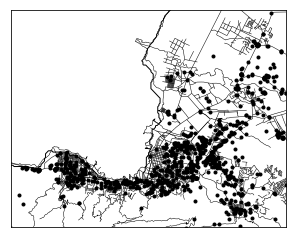

In [6]:
#-*- coding: utf-8 -*-
import pandas as pd
import numpy as np
from pandas import DataFrame

#Hack to fix missing PROJ4 env var
import os
import conda

conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline
#2010年海地地震以及余震期间收集的数据

data = pd.read_csv('code/pydata-book/datasets/haiti/haiti.csv')
#print(data)
#print(data[['INCIDENT DATE','LATITUDE','LONGITUDE']][:10])
#CATEGORY字段含有一组以逗号为分隔符的代码
#print(data['CATEGORY'][:6])
#仔细观察这个数据摘要会发现有些分类信息丢失了，因此我们需要丢弃这些数据点
#print(data.describe())
#有些异常的地理位置
#移除异常数据
data = data[(data.LATITUDE > 18) & (data.LATITUDE < 20) & (data.LONGITUDE > -75) & (data.LONGITUDE < -70) & data.CATEGORY.notnull()]

#对数据进行规范化处理
#各个分类字段中可能含有多个分类，此外，各个分类信息不仅有一个编码，还有一个英文名称（可能还有一个语法名称）
def to_cat_list(catstr):
    stripped = (x.strip() for x in catstr.split(','))
    return [x for x in stripped if x]

def get_all_categeries(cat_series):
    cat_sets = (set(to_cat_list(x)) for x in cat_series)
    return sorted(set.union(*cat_sets))

def get_english(cat):
    code, names = cat.split('.')
    if '|' in names:
        names = names.split(' | ')[1]
    return code,names.strip()
#test
#print(get_english('2. Urgences logistiques | Vital Lines, '))

all_cats = get_all_categeries(data.CATEGORY)
english_mapping = dict(get_english(x) for x in all_cats)
#print(english_mapping)

def get_code(seq):
    return [x.split('.')[0] for x in seq if x]

all_codes = get_code(all_cats)
code_index = pd.Index(np.unique(all_codes))
dummy_frame = DataFrame(np.zeros((len(data),len(code_index))),index=data.index,columns=code_index)
#print(dummy_frame.ix[:,:6])

for row, cat in zip(data.index,data.CATEGORY):
    codes = get_code(to_cat_list(cat))
#     dummy_frame.ix[row,codes] = 1
    dummy_frame.loc[row,codes] = 1

data = data.join(dummy_frame.add_prefix('category_'))

#print(data.ix[:,10:15])
#Basemap是Matplotlib的一个子包，负责地图绘制。在数据可视化过程中，我们常需要将数据在地图上画出来。
def basic_haiti_map(ax=None,lllat=17.25,urlat=20.25,lllon=-75,urlon=-71):
    #创建极球面投影的basemap实例
    m = Basemap(ax=ax, projection='stere',lon_0=(urlon + lllon) / 2,lat_0=(urlat + lllat) / 2,llcrnrlat=lllat,urcrnrlat=urlat,llcrnrlon=lllon,urcrnrlon=urlon,resolution='f')
    #绘制海岸线、州界、国界以及地图边界
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()
    return m

#fig, axes = plt.subplots(nrows=1,ncols=1)
#fig.subplots_adjust(hspace=0.05,wspace=0.05)
# '1','3c','7a'
# 大部分数据都集中在人口稠密的太子港，加载来自shapefile的地图数据;我们只加载食物短缺在太子港附近的数据
to_plot = ['2a']
lllat = 18.50;urlat = 18.65;lllon=-72.45;urlon=-72.25
for code,ax in zip(to_plot,['1']):
    m = basic_haiti_map(None,lllat=lllat,urlat=urlat,lllon=lllon,urlon=urlon)
    cat_data = data[data['category_%s' % code] == 1]
    #计算地图的投影坐标
    x, y = m(cat_data.LONGITUDE.tolist(),cat_data.LATITUDE.tolist())
    shapefile_path = 'code/pydata-book/datasets/haiti/PortAuPrince_Roads/PortAuPrince_Roads'
    m.readshapefile(shapefile_path, 'roads')
    m.plot(x,y,'k.')
    #ax.set_title('%s: %s' % (code,english_mapping[code]))

plt.show()